In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Set number of threads
tf.config.threading.set_intra_op_parallelism_threads(96)  # Use all logical cores
tf.config.threading.set_inter_op_parallelism_threads(2)   # Experiment with inter-op threads
# Enable XLA JIT compilation
tf.config.optimizer.set_jit(True)

2024-10-13 07:20:01.004404: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 07:20:01.011443: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 07:20:01.036607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 07:20:01.112515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 07:20:01.125200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 07:20:01.154448: I tensorflow/core/platform/cpu_feature_gu

In [2]:
#with strategy.scope():
# Load the dataset
data = np.load('/home/showv/BanglaOCR/AP-Model Training/Dataset/AGE_1024_512_Class5.npz') #/home/showv/BanglaOCR/Dataset
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1)) #.astype(np.float16)  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1)) #.astype(np.float16)
    
# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [3]:
# # !echo $CUDA_VISIBLE_DEVICES
# # !export CUDA_VISIBLE_DEVICES=0,1

# import tensorflow as tf

# # Check if GPU is available
# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [4]:
# import tensorflow as tf

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# # Create a strategy for distributed training
# strategy = tf.distribute.MirroredStrategy()

In [5]:
#with strategy.scope():
#with tpu_strategy.scope():
# Define the base model with ImageNet weights, without the top layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
inputs = Input(shape=(512, 1024, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(128, activation='relu')(x)  # Custom dense layer
outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes

# Create the final model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 16, 32, 1920)   │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,568,517 (70.83 MB)

 Trainable params: 246,533 (963.02 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [3]:
class SaveHistory(Callback):
    def __init__(self, filename):
        super(SaveHistory, self).__init__()
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        # If the file exists, load the previous history
        try:
            with open(self.filename, 'r') as f:
                history = json.load(f)
        except FileNotFoundError:
            history = {}
        
        # Append new logs to the history
        for key, value in logs.items():
            if key not in history:
                history[key] = []
            history[key].append(value)
        
        # Save the updated history to file
        with open(self.filename, 'w') as f:
            json.dump(history, f)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('AP-DenseNet201_1024Age_checkpoint.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
history_callback = SaveHistory('AP-DenseNet201_1024Age_history.json')

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=64,
                    callbacks=[early_stopping, checkpoint, history_callback])

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1719s 12s/step - accuracy: 0.2774 - loss: 1.6000 - val_accuracy: 0.3801 - val_loss: 1.4515
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1556s 11s/step - accuracy: 0.3876 - loss: 1.4291 - val_accuracy: 0.4268 - val_loss: 1.3676
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1571s 11s/step - accuracy: 0.4409 - loss: 1.3509 - val_accuracy: 0.4561 - val_loss: 1.3234
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1498s 10s/step - accuracy: 0.4667 - loss: 1.3180 - val_accuracy: 0.4849 - val_loss: 1.2914
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1542s 11s/step - accuracy: 0.4650 - loss: 1.2978 - val_accuracy: 0.4644 - val_loss: 1.2774
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1494s 10s/step - accuracy: 0.4839 - loss: 1.2594 - val_accuracy: 0.4854 - val_loss: 1.2560
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1507s 10s/step - accuracy: 0.4864 - loss: 1.2455 - val_accuracy: 0.4827 - val_loss: 1.2452
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1576s 11s/step - accuracy: 0.4874 -

In [ ]:
#Load the saved model and history
from tensorflow.keras.models import load_model

model = load_model('AP-DenseNet201_1024Age_checkpoint.keras')
with open('AP-DenseNet201_1024Age_history.json', 'r') as f:
    history = json.load(f)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=90,  # You can increase epochs based on performance
                    batch_size=64,
                    callbacks=[early_stopping, checkpoint, history_callback])

Epoch 1/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1772s 12s/step - accuracy: 0.4993 - loss: 1.2019 - val_accuracy: 0.5155 - val_loss: 1.1943
Epoch 2/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1726s 12s/step - accuracy: 0.5093 - loss: 1.1801 - val_accuracy: 0.5076 - val_loss: 1.1900
Epoch 3/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1733s 12s/step - accuracy: 0.5151 - loss: 1.1788 - val_accuracy: 0.5190 - val_loss: 1.1860
Epoch 4/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1571s 11s/step - accuracy: 0.5216 - loss: 1.1656 - val_accuracy: 0.4806 - val_loss: 1.2130
Epoch 5/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1542s 11s/step - accuracy: 0.5142 - loss: 1.1672 - val_accuracy: 0.5159 - val_loss: 1.1770
Epoch 6/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1544s 11s/step - accuracy: 0.5155 - loss: 1.1688 - val_accuracy: 0.5229 - val_loss: 1.1718
Epoch 7/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1532s 11s/step - accuracy: 0.5159 - loss: 1.1603 - val_accuracy: 0.5133 - val_loss: 1.1669
Epoch 8/90
144/144 ━━━━━━━━━━━━━━━━━━━━ 1541s 11s/step - accuracy: 0.5218 - loss: 1

In [4]:
#Load the saved model and history
from tensorflow.keras.models import load_model

model = load_model('AP-DenseNet201_1024Age_checkpoint.keras')
with open('AP-DenseNet201_1024Age_history.json', 'r') as f:
    history = json.load(f)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,  # You can increase epochs based on performance
                    batch_size=64,
                    callbacks=[early_stopping, checkpoint, history_callback])

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1753s 12s/step - accuracy: 0.6039 - loss: 1.0075 - val_accuracy: 0.5688 - val_loss: 1.0643
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1714s 12s/step - accuracy: 0.6060 - loss: 0.9997 - val_accuracy: 0.5775 - val_loss: 1.0585
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1708s 12s/step - accuracy: 0.5980 - loss: 1.0067 - val_accuracy: 0.5579 - val_loss: 1.0731
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1687s 12s/step - accuracy: 0.6041 - loss: 1.0047 - val_accuracy: 0.5745 - val_loss: 1.0560
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1664s 12s/step - accuracy: 0.5977 - loss: 1.0072 - val_accuracy: 0.5749 - val_loss: 1.0547
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1595s 11s/step - accuracy: 0.6043 - loss: 0.9969 - val_accuracy: 0.5714 - val_loss: 1.0525
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1582s 11s/step - accuracy: 0.6017 - loss: 0.9991 - val_accuracy: 0.5679 - val_loss: 1.0593
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1649s 11s/step - accuracy: 0.6033 - loss: 0

In [5]:
# Save the model in .keras format
model.save('AP-DenseNet201_Model_1024Age_Trained.keras')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.5966 - loss: 0.9954
Test accuracy: 60.16%


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

72/72 ━━━━━━━━━━━━━━━━━━━━ 352s 5s/step
Accuracy: 0.601572739187418
Precision: 0.595898975320656
Recall: 0.6052102881380492
F1 Score: 0.5978164227950117
Number of Epochs: 50
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


72/72 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step


<Figure size 1600x1600 with 0 Axes>

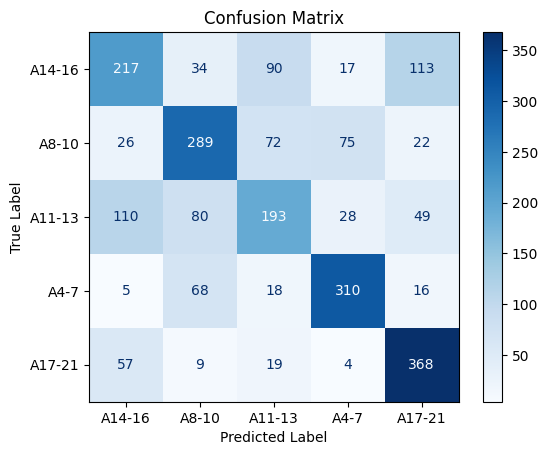

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

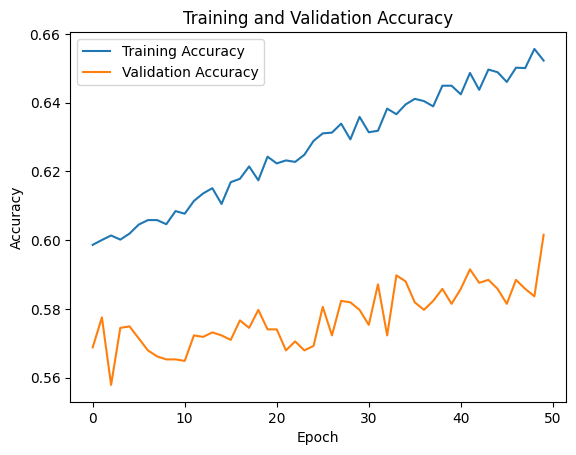

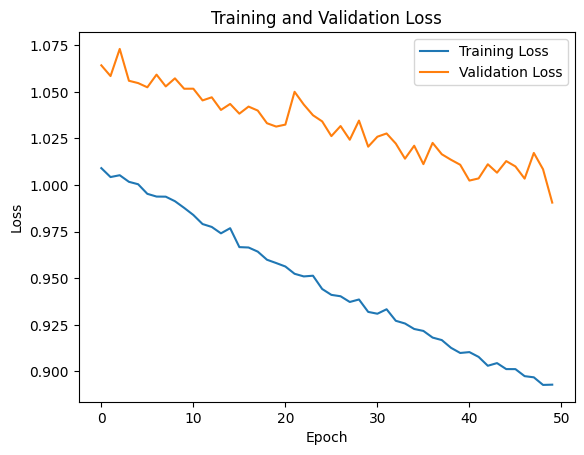

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()